## Курсовой проект для курса "Python для Data Science"

### Информация

Материалы к проекту (файлы): train.csv, test.csv

Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

Целевая переменная: Price

Основная метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:

Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
Необходимо получить R2 > 0.6 на Private Leaderboard.

Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

**Подключение библиотек и скриптов**

In [1]:
#Работа с данными
import numpy as np
import pandas as pd

#Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

#Масштабирование
from sklearn.preprocessing import MinMaxScaler

#Разбиение на train/test
from sklearn.model_selection import train_test_split

#Модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

#Подбор гиперпараметров
from sklearn.model_selection import KFold, GridSearchCV

#Оценка модели
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

#Статистика
from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

**Пути к директориям и файлам**

In [2]:
DATASET_TRAIN_PATH = './train.csv'
DATASET_TEST_PATH = './test.csv'
PREPARED_DATASET_PATH = './train_prepared.csv'
FINAL_RESULT = './VKamenskikh_predictions.csv'

**Загрузка данных**

In [3]:
train = pd.read_csv(DATASET_TRAIN_PATH)
test = pd.read_csv(DATASET_TEST_PATH)

In [4]:
train.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027311         NaN           10.0      4   
1   3013          22    1.0   39.832524   23.169223            8.0      7   
2   8215           1    3.0   78.342215   47.671972           10.0      2   
3   2352           1    1.0   40.409907         NaN            1.0     10   
4  13866          94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424         B         B        11      3097   
1         8.0       1966   0.118537         B         B        30      6207   
2        17.0       1988   0.025609         B         B        33      5261   
3        22.0       1977   0.007122         B         B         1       264   
4        16.0       1972   0.282798         B         B        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         0           NaN            0        0       B  305018.871089  
1         1        1183.0            1        0       B  177734.553407  
2         0         240.0            3        1       B  282078.720850  
3         0           NaN            0        1       B  168106.007630  
4         2           NaN            0        6       B  343995.102962

In [5]:
test.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  4567          44    1.0  36.847630   19.094182            5.0      5   
1  5925          62    1.0  42.493907   42.568133           10.0      7   
2   960          27    2.0  59.463678         NaN            9.0     19   
3  3848          23    3.0  49.646030   33.893825            6.0      2   
4   746          74    1.0  53.837056         NaN            1.0      8   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1970   0.036122         B         B        24      4378   
1        17.0       2017   0.072158         B         B         2       629   
2        19.0       1977   0.211401         B         B         9      1892   
3         2.0       1965   0.014073         B         B         2       475   
4        17.0       1977   0.309479         B         B        35      7715   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         0        1036.0            1        1       B  
1         1           NaN            0        0       A  
2         0           NaN            0        1       B  
3         0           NaN            0        0       B  
4         4         990.0            0        6       B

**Оптимизация потребления памяти**

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
reduce_mem_usage(train)
reduce_mem_usage(test)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0      4567          44    1.0  36.847630   19.094183            5.0      5   
1      5925          62    1.0  42.493908   42.568134           10.0      7   
2       960          27    2.0  59.463676         NaN            9.0     19   
3      3848          23    3.0  49.646030   33.893826            6.0      2   
4       746          74    1.0  53.837055         NaN            1.0      8   
...     ...         ...    ...        ...         ...            ...    ...   
4995  10379          29    2.0  43.177521   30.339945            5.0      6   
4996  16138          38    3.0  93.698120   94.521461           10.0     21   
4997   3912         101    1.0  33.656723   19.003260            5.0      2   
4998   5722          10    1.0  38.635155   20.976257            9.0      8   
4999  11004          21    2.0  67.122742   33.944344           13.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
0            9.0       1970   0.036122         B         B        24   
1           17.0       2017   0.072158         B         B         2   
2           19.0       1977   0.211401         B         B         9   
3            2.0       1965   0.014073         B         B         2   
4           17.0       1977   0.309479         B         B        35   
...          ...        ...        ...       ...       ...       ...   
4995         5.0       1962   0.069660         B         B        31   
4996        27.0       2018   0.060753         B         B        15   
4997         5.0       1966   0.038693         B         B        28   
4998        14.0       1970   0.089040         B         B        33   
4999        17.0       2009   0.194489         B         B        47   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         4378         0        1036.0            1        1       B  
1          629         1           NaN            0        0       A  
2         1892         0           NaN            0        1       B  
3          475         0           NaN            0        0       B  
4         7715         4         990.0            0        6       B  
...        ...       ...           ...          ...      ...     ...  
4995      6119         4           NaN            1        2       B  
4996      2787         2         520.0            0        7       B  
4997      6533         1        1015.0            2        5       B  
4998      7976         5           NaN            0       11       B  
4999      8004         3         125.0            3        5       B  

[5000 rows x 19 columns]

**Анализ данных**

In [8]:
concat_df = pd.concat((train, test), sort=False).reset_index(drop=True)
concat_df.drop(['Price'], axis=1, inplace=True)

In [9]:
concat_df.describe()

Id    DistrictId         Rooms        Square    LifeSquare  \
count  15000.000000  15000.000000  15000.000000  15000.000000  11846.000000   
mean    8393.136933     50.693600      1.897000     56.360554     36.851757   
std     4850.111673     43.786257      0.839269     20.423906     71.120193   
min        0.000000      0.000000      0.000000      1.136859      0.333490   
25%     4188.750000     20.000000      1.000000     41.814370     22.896130   
50%     8378.500000     37.000000      2.000000     52.645758     32.822811   
75%    12594.250000     75.000000      2.000000     66.036606     45.144627   
max    16798.000000    212.000000     19.000000    641.065186   7480.592285   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   15000.000000  15000.000000  15000.000000  1.500000e+04  15000.000000   
mean        6.174467      8.561800     12.606600  3.321575e+03      0.119195   
std        24.017342      5.323113      6.780309  1.637078e+05      0.119371   
min         0.000000      1.000000      0.000000  1.908000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     12.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     78.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  15000.000000  15000.000000  15000.000000   7825.000000  15000.000000   
mean      24.769267   5370.404933      8.113667   1144.162476      1.319467   
std       17.532278   4013.364403     23.841946   1029.307251      1.489012   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7287.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1  
count  15000.000000  
mean       4.235133  
std        4.796545  
min        0.000000  
25%        1.000000  
50%        3.000000  
75%        6.000000  
max       23.000000

**Признак 'Square'**

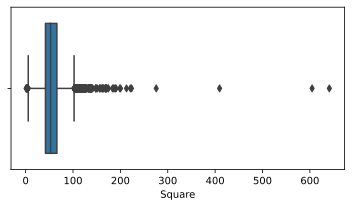

In [10]:
plt.figure(figsize=(6, 3))

sns.boxplot(concat_df['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

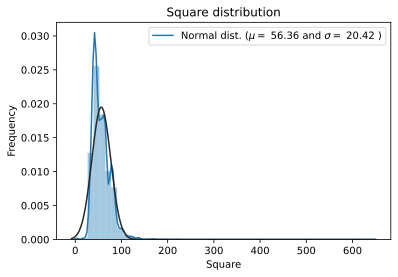

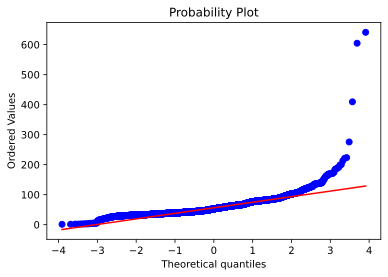

In [11]:
sns.distplot(concat_df['Square'], fit=norm)

mu, sigma = norm.fit(concat_df['Square'])

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'])
plt.ylabel('Frequency')
plt.title('Square distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(concat_df['Square'], plot=plt)
plt.show()

### Анализ целевой переменной

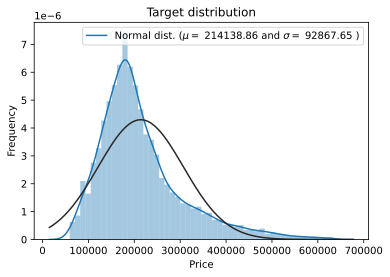

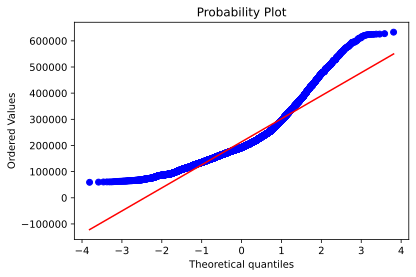

In [12]:
sns.distplot(train['Price'], fit=norm)

mu, sigma = norm.fit(train['Price'])

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'])
plt.ylabel('Frequency')
plt.title('Target distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['Price'], plot=plt)
plt.show()

In [13]:
target_mean = round(train['Price'].mean(), 2)
target_median = train['Price'].median()
target_mode = train['Price'].mode()[0]

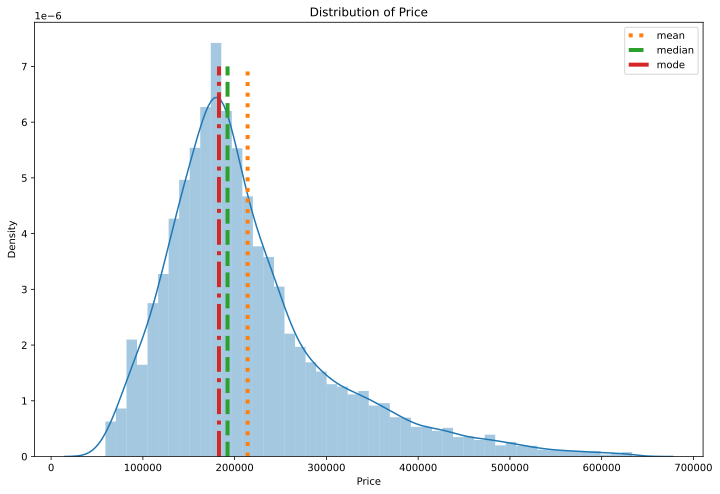

In [14]:
plt.figure(figsize = (12, 8))

sns.distplot(train['Price'], bins=50)

y = np.linspace(0, 0.000007, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

**Формируем PipeLine**

In [15]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.means = None
        self.sigma = None
                
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет средних
        self.means = df.mean()
        
        #Расчет сигмы для общей площади
        self.sigma = np.sqrt(np.var(df['Square'], ddof=1))
               
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        df[['LifeSquare', 'Healthcare_1']] = df[['LifeSquare', 'Healthcare_1']].fillna(self.means)
        
        
        # 2. Выбросы (outliers)
        
        #Устанавливаем значения жилой площади больше общей площади равными общей площади
        df.loc[df['Square'] < df['LifeSquare'], 'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']
        
        #Убираем дома из будущего
        df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
        df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
        
        
        # 3. Новые фичи (features)
        
        #Расчет средней площади комнаты сгруппированных по Id района и году постройки
        group_by_district_id = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
        {'Rooms': 'sum', 'Square': 'sum'}).rename(
        columns={'Rooms': 'sum_rooms_dr', 'Square': 'sum_square_dr'})

        group_by_district_id['mean_square_per_room'] = group_by_district_id['sum_square_dr'] \
        / group_by_district_id['sum_rooms_dr']
    
        group_by_district_id.drop(['sum_square_dr', 'sum_rooms_dr'], axis=1, inplace=True)

        df = pd.merge(df, group_by_district_id, on=[
                  'DistrictId', 'HouseYear'], how='left')
        
        #Пересчитываем значения комнат больше 6 и равные 0
        df.loc[df['Rooms'] > 6, 'Rooms'] = (df.loc[df['Rooms'] > 6, 'Square'] 
                                        // df.loc[df['Rooms'] > 6, 'mean_square_per_room']).astype('int16')

        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    
        
        #Добавляем среднее значение общей площади по группировке Id района, кол-ва комнат и года постройки
        info_by_rooms_district_id = df.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg(
        {'Square': 'mean'}).rename(
        columns={'Square': 'mean_square_rooms_dr'})
        
        df = pd.merge(df, info_by_rooms_district_id, on=['DistrictId', 'Rooms', 'HouseYear'], how='left')
        
        df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * self.sigma, 'Square'] \
                = df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * self.sigma, 'Rooms'] \
                * df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * self.sigma, 'mean_square_per_room']
        
        df.fillna(self.means, inplace=True)      
        return df

In [16]:
pipe = DataPipeline()
pipe.fit(train)
df = pipe.transform(train)

df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')

In [17]:
prep_train = pd.read_csv(PREPARED_DATASET_PATH)

In [18]:
prep_train

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0     11809          27    3.0  115.027310   37.199665           10.0      4   
1      3013          22    1.0   39.832523   23.169222            8.0      7   
2      8215           1    3.0   78.342220   47.671970           10.0      2   
3      2352           1    1.0   40.409910   37.199665            1.0     10   
4     13866          94    2.0   64.285065   38.562515            9.0     16   
...     ...         ...    ...         ...         ...            ...    ...   
9995   1260          61    2.0   49.090730   33.272625            6.0      3   
9996  16265          27    2.0   64.307686   37.038420            9.0     13   
9997   2795         178    1.0   29.648056   16.555363            5.0      3   
9998  14561          21    1.0   32.330290   22.326870            5.0      3   
9999   7202          94    1.0   35.815475   22.301367            6.0      9   

      HouseFloor  HouseYear  Ecology_1  ... Social_1 Social_2  Social_3  \
0           10.0       2014   0.075424  ...       11     3097         0   
1            8.0       1966   0.118537  ...       30     6207         1   
2           17.0       1988   0.025609  ...       33     5261         0   
3           22.0       1977   0.007122  ...        1      264         0   
4           16.0       1972   0.282798  ...       33     8667         2   
...          ...        ...        ...  ...      ...      ...       ...   
9995        12.0       1981   0.300323  ...       52    10311         6   
9996         0.0       1977   0.072158  ...        2      629         1   
9997         5.0       1958   0.460556  ...       20     4386        14   
9998         9.0       1969   0.194489  ...       47     8004         3   
9999         9.0       1975   0.127376  ...       43     8429         3   

      Healthcare_1  Helthcare_2  Shops_1  Shops_2      Price  \
0        1142.9044            0        0        B  305018.88   
1        1183.0000            1        0        B  177734.55   
2         240.0000            3        1        B  282078.72   
3        1142.9044            0        1        B  168106.00   
4        1142.9044            0        6        B  343995.10   
...            ...          ...      ...      ...        ...   
9995     1142.9044            1        9        B  119367.45   
9996     1142.9044            0        0        A  199715.16   
9997     1142.9044            1        5        B  165953.90   
9998      125.0000            3        5        B  171842.40   
9999     1142.9044            3        9        B  177685.62   

     mean_square_per_room  mean_square_rooms_dr  
0               33.306625             81.985120  
1               28.320198             36.508575  
2               29.920725             78.342220  
3               33.381184             44.089996  
4               26.996244             62.453130  
...                   ...                   ...  
9995            24.956097             49.325035  
9996            32.964172             64.721375  
9997            29.648056             29.648056  
9998            26.697308             34.510674  
9999            29.352194             37.180500  

[10000 rows x 22 columns]

**Матрица корреляций**

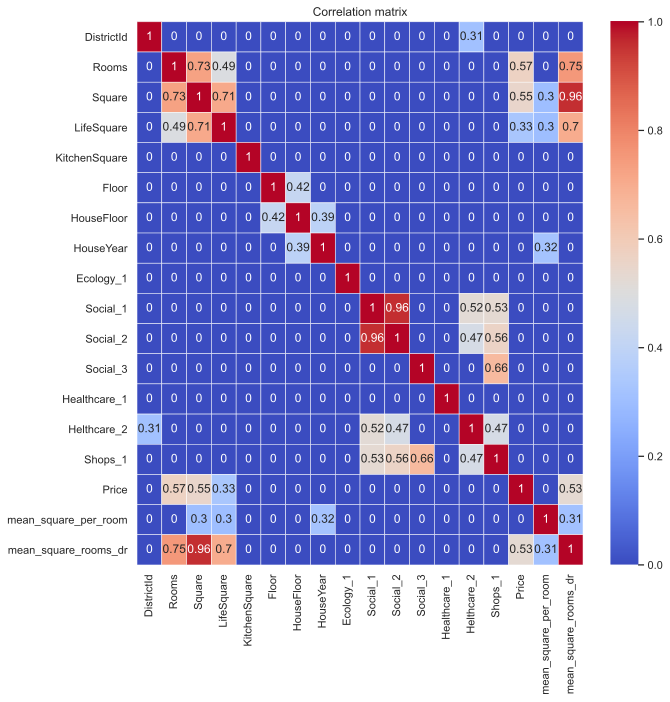

In [19]:
prep_train = prep_train.drop('Id', axis=1)
plt.figure(figsize = (10,10))

sns.set(font_scale=1)

corr_matrix = prep_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Построение модели

In [20]:
features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
            'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 
            'mean_square_per_room', 'mean_square_rooms_dr']
target = 'Price'

In [21]:
prep_train[features].head()

Rooms      Square  LifeSquare  KitchenSquare  Floor  HouseFloor  HouseYear  \
0    3.0  115.027310   37.199665           10.0      4        10.0       2014   
1    1.0   39.832523   23.169222            8.0      7         8.0       1966   
2    3.0   78.342220   47.671970           10.0      2        17.0       1988   
3    1.0   40.409910   37.199665            1.0     10        22.0       1977   
4    2.0   64.285065   38.562515            9.0     16        16.0       1972   

   Ecology_1  Social_1  Social_2  Social_3  Healthcare_1  Helthcare_2  \
0   0.075424        11      3097         0     1142.9044            0   
1   0.118537        30      6207         1     1183.0000            1   
2   0.025609        33      5261         0      240.0000            3   
3   0.007122         1       264         0     1142.9044            0   
4   0.282798        33      8667         2     1142.9044            0   

   Shops_1  mean_square_per_room  mean_square_rooms_dr  
0        0             33.306625             81.985120  
1        0             28.320198             36.508575  
2        1             29.920725             78.342220  
3        1             33.381184             44.089996  
4        6             26.996244             62.453130

In [22]:
prep_train[5894:5895].mean_square_per_room = prep_train.mean_square_per_room.median() #появилось inf значение, заменил его

**Разбиение модели на train/test**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(prep_train[features], prep_train[target], test_size=0.3, random_state=42)

**Обучение модели**

In [24]:
lgbm_model = LGBMRegressor(
    max_bin=110,
    num_leaves=4,
    n_estimators=4000,
    learning_rate=0.01
)
lgbm_model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.01, max_bin=110, n_estimators=4000, num_leaves=4)

**Оценка модели**

In [25]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.778
RMSE:	43094.992
MSE:	1857178372.234


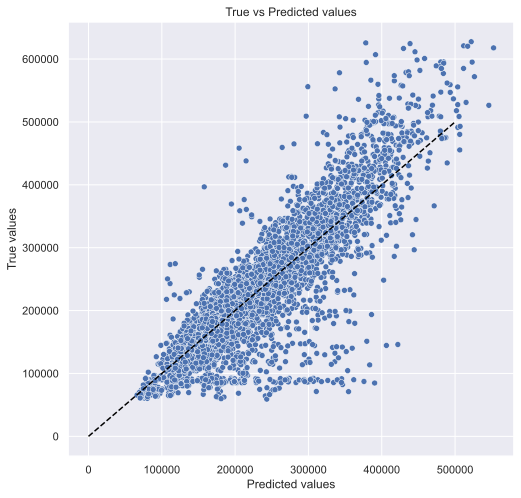

R2:	0.726
RMSE:	50247.636
MSE:	2524824954.122


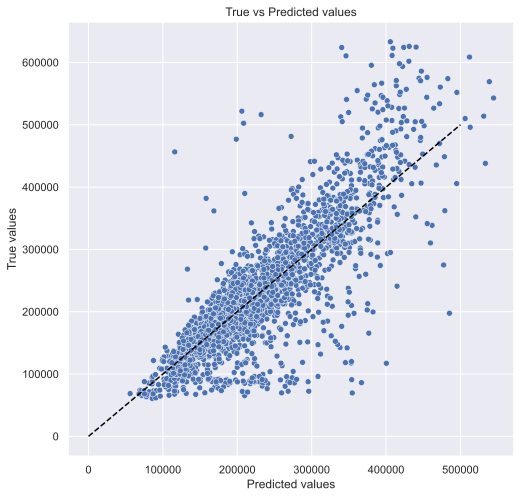

In [26]:
y_train_preds = lgbm_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)
y_test_preds = lgbm_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [27]:
feature_importances = pd.DataFrame(zip(X_train.columns,lgbm_model.feature_importances_),
                                   columns=['feature', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

feature  importance
6              HouseYear        1172
7              Ecology_1        1144
1                 Square        1134
10              Social_3        1044
14  mean_square_per_room         915
9               Social_2         914
11          Healthcare_1         912
8               Social_1         854
15  mean_square_rooms_dr         720
2             LifeSquare         709
5             HouseFloor         691
3          KitchenSquare         636
13               Shops_1         462
4                  Floor         381
12           Helthcare_2         164
0                  Rooms         148

**Предсказание 'test.csv'**

In [28]:
pipe_test = DataPipeline()
pipe_test.fit(test)
df_test = pipe_test.transform(test)

In [29]:
df_test

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0      4567          44    1.0  36.847630   19.094183            5.0      5   
1      5925          62    1.0  42.493908   42.493908           10.0      7   
2       960          27    2.0  59.463676   36.158756            9.0     19   
3      3848          23    3.0  49.646030   33.893826            6.0      2   
4       746          74    1.0  53.837055   36.158756            1.0      8   
...     ...         ...    ...        ...         ...            ...    ...   
4995  10379          29    2.0  43.177521   30.339945            5.0      6   
4996  16138          38    3.0  93.698120   93.698120           10.0     21   
4997   3912         101    1.0  33.656723   19.003260            5.0      2   
4998   5722          10    1.0  38.635155   20.976257            9.0      8   
4999  11004          21    2.0  67.122742   33.944344           13.0      9   

      HouseFloor  HouseYear  Ecology_1  ... Ecology_3 Social_1  Social_2  \
0            9.0       1970   0.036122  ...         B       24      4378   
1           17.0       2017   0.072158  ...         B        2       629   
2           19.0       1977   0.211401  ...         B        9      1892   
3            2.0       1965   0.014073  ...         B        2       475   
4           17.0       1977   0.309479  ...         B       35      7715   
...          ...        ...        ...  ...       ...      ...       ...   
4995         5.0       1962   0.069660  ...         B       31      6119   
4996        27.0       2018   0.060753  ...         B       15      2787   
4997         5.0       1966   0.038693  ...         B       28      6533   
4998        14.0       1970   0.089040  ...         B       33      7976   
4999        17.0       2009   0.194489  ...         B       47      8004   

      Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2  \
0            0   1036.000000            1        1        B   
1            1   1146.657227            0        0        A   
2            0   1146.657227            0        1        B   
3            0   1146.657227            0        0        B   
4            4    990.000000            0        6        B   
...        ...           ...          ...      ...      ...   
4995         4   1146.657227            1        2        B   
4996         2    520.000000            0        7        B   
4997         1   1015.000000            2        5        B   
4998         5   1146.657227            0       11        B   
4999         3    125.000000            3        5        B   

     mean_square_per_room  mean_square_rooms_dr  
0               27.871181             30.910749  
1               36.596817             42.493908  
2               33.425919             64.809578  
3               16.548677             49.646030  
4               41.704727             50.038757  
...                   ...                   ...  
4995            21.453032             44.299175  
4996            31.232706             93.698120  
4997            24.975811             32.924397  
4998            28.695837             38.635155  
4999            33.561371             67.122742  

[5000 rows x 21 columns]

In [30]:
test_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
            'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 
            'mean_square_per_room', 'mean_square_rooms_dr']

In [31]:
df_test['Price'] = lgbm_model.predict(df_test[test_features])

mu = 215710.47 and sigma = 77241.96


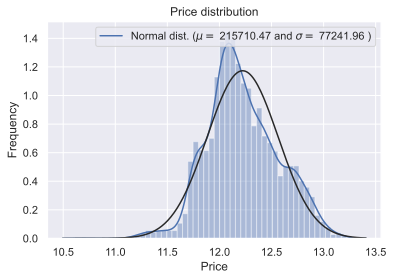

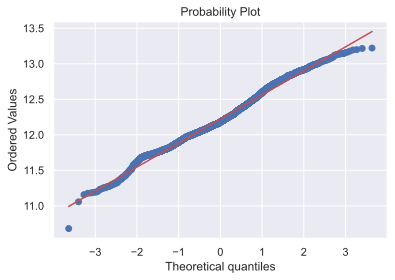

In [32]:
price_log = np.log1p(df_test['Price'])
sns.distplot(price_log, fit=norm)

mu, sigma = norm.fit(df_test['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

In [33]:
df_test[['Id', 'Price']].to_csv(FINAL_RESULT, index=None)